In [6]:
import networkx as nx

import input_functions as inp
import tsp_routines
from clustering.funcs import k_cluster
from clustering.funcs import best_dropoff
from input_functions.funcs import create_new_graph

In [7]:
def map_dict_entries(input_dict,nodemapper):
    """
    maps the keys and values of the input dict using the nodemapper dict.
    """
    output_dict = dict()
    for key in input_dict.keys():
        mapped_key = nodemapper[key]
        output_dict.update({mapped_key:[]})
        for vertex in input_dict[key]:
            output_dict[mapped_key].append(nodemapper[vertex])
    return output_dict

def tsp_solution_to_path(G,tsp_route):
    """
    converts the given tsp sequence to be followed by the car into a 
    path in the graph G
    Input:
    G - undirected weighted input graph
    tsp_route - list of vertices specifying the route to be followed by the car
    """
    prev = tsp_route[0]
    final_path = []
    final_path.append(prev)
    for vertex in tsp_route[1:]:
        path = nx.shortest_path(G,prev,vertex,weight='weight')
        final_path += path[1:]
        prev = vertex
    return final_path

def add_vertex_to_clusters(clusters,vertex):
    """
    add the given vertex to each cluster.
    Input:
    clusters - dict where the keys are vertices which are cluster centers and the values are a list of 
                vertices belonging to this cluster
    vertex - the vertex to be added to each list in `clusters`
    """
    for key in clusters:
        clusters[key].append(vertex)
        
def get_dropoff_vertices(clusters):
    best_dropoffs = []
    for key in clusters:
        dropoff = best_dropoff(G,clusters[key])
        best_dropoffs.append(dropoff)
    return best_dropoffs
        
def solve_by_clustering(graph,homes,source,num_clusters):
    """
    return the route to be followed by the car as it drops off TAs.
    Inputs:
    graph - input graph
    homes - list of vertices in `graph` that are marked as homes
    source - vertex in `graph` that is the start and end of the path followed by the car
    num_clusters - the number of clusters to be used to group the homes together
    """
    homes_subgraph = tsp_routines.complete_shortest_path_subgraph(graph,homes)
    home_clusters = k_cluster(homes_subgraph,num_clusters)
    # The source vertex is added to each of the clusters before determining the best dropoff location.
    # This is done so that vertices that are closer to the source are given higher preference as dropoff points.
    add_vertex_to_clusters(home_clusters,source)
    dropoff_vertices = get_dropoff_vertices(home_clusters)
    # Add the source to the dropoff vertices
    dropoff_vertices.append(source)
    # Get rid of any repeating entries in the dropoff vertices
    dropoff_vertices = list(set(dropoff_vertices))
    # Construct the fully connected sub-graph with the dropoff vertices 
    # on which TSP is computed
    dropoff_subgraph = tsp_routines.complete_shortest_path_subgraph(graph,dropoff_vertices)
    tsp_route = tsp_routines.metric_mst_tsp(dropoff_subgraph,source)
    final_path = tsp_solution_to_path(graph,tsp_route)
    return final_path
    

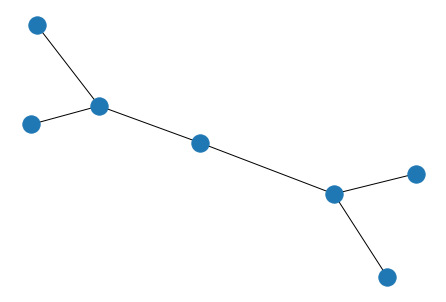

In [8]:
G = nx.Graph()
G.add_edge(1,2,weight=1)
G.add_edge(2,3,weight=2)
G.add_edge(2,4,weight=1)
G.add_edge(1,5,weight=2)
G.add_edge(5,6,weight=1)
G.add_edge(5,7,weight=3)
nx.draw(G)

In [9]:
homes = [3,4,6,7]
final_path = solve_by_clustering(G,homes,1,2)
print(final_path)

[1, 2, 1, 5, 1]
